In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import gc
import nltk
from collections import Counter
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.python.client import device_lib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

%matplotlib inline

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Steven\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#check for available devices

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4817945092720243966
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9226016523
locality {
  bus_id: 1
}
incarnation: 10279780316611074972
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
stemmer = SnowballStemmer('english')

In [3]:
#functions - warning these are slow

def word_tokenize(text, how = 'lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def spelling(text):
    words = TextBlob(text).words
    return [word.correct() for word in words]

### Exploratory Data Analysis

1. Handle missing data
2. Distribution of toxic tags
3. Comment length analysis
4. Sentiment analysis
    - Polarity
    - Subjectivity
5. Special character count
6. Part of speech analysis (incomplete)
7. Other ideas (all not started)
    - Unique tokens, lexical diversity
    - Token lengths
    - Tokens per sentence
    - Spelling (using Jaccard distance)

In [4]:
#load in csv files and preview training set

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_ids = train['id']
test_ids = test['id']

del train['id']
del test['id']

train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#preview test set

test.head()

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.


In [7]:
#train info

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [8]:
#test info

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
comment_text    153164 non-null object
dtypes: object(1)
memory usage: 1.2+ MB


In [6]:
train.fillna(' ', inplace = True)
test.fillna(' ', inplace = True)

In [10]:
#how many rows of train and test

print('train = ' + str(train.shape))
print('test = ' + str(test.shape))

train = (159571, 7)
test = (153164, 1)


In [11]:
#counts

print('toxic = ' + str(train['toxic'].sum()))
print('severe toxic = ' + str(train['severe_toxic'].sum()))
print('obscene = ' + str(train['obscene'].sum()))
print('threat = ' + str(train['threat'].sum()))
print('insult = ' + str(train['insult'].sum()))
print('identity_hate = ' + str(train['identity_hate'].sum()))

toxic = 15294
severe toxic = 1595
obscene = 8449
threat = 478
insult = 7877
identity_hate = 1405


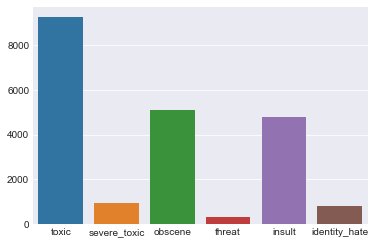

In [12]:
#distribution of toxic categories

sns.set_style('darkgrid')
sns.barplot(x = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], y = [9237, 965, 5109, 305, 4765, 814])

In [13]:
#define binary response for analysis, can see that comment can contain multiple tags

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
train.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0
159570,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0,0


In [14]:
#length of comment

print('average characters toxic = ' + str(np.mean(train.comment_text[train['toxic_all'] >= 1].str.len())))
print('average characters non-toxic = ' + str(np.mean(train.comment_text[train['toxic_all'] == 0].str.len())))
print('median characters toxic = ' + str(np.median(train.comment_text[train['toxic_all'] >= 1].str.len())))
print('median characters non-toxic = ' + str(np.median(train.comment_text[train['toxic_all'] == 0].str.len())))

average characters toxic = 303.30403697996917
average characters non-toxic = 404.3471739706724
median characters toxic = 128.0
median characters non-toxic = 216.0


In [15]:
train['comment_length'] = train['comment_text'].str.len()
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all,comment_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67


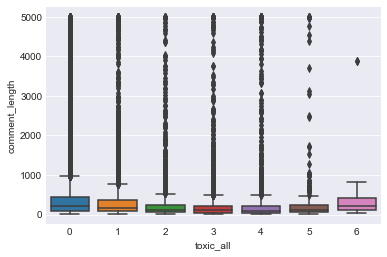

In [16]:
#boxplot x = comment category, y = length of comment text

sns.boxplot(x = train['toxic_all'], y = train['comment_length'])

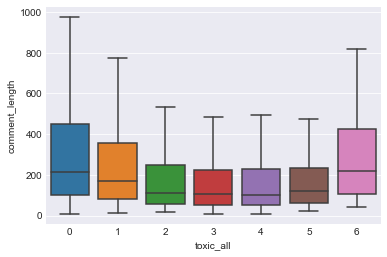

In [17]:
#exclude outliers

sns.boxplot(x = train['toxic_all'], y = train['comment_length'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


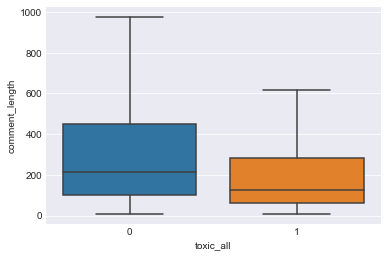

In [18]:
#boolean response boxplot

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['comment_length'], showfliers = False)

In [19]:
#sentiment analysis

train['sentiment'] = train['comment_text'].apply(lambda x: TextBlob(x).sentiment)
train[['sentiment_polarity', 'sentiment_subjectivity']] = train['sentiment'].apply(pd.Series)
del train['sentiment']
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all,comment_length,sentiment_polarity,sentiment_subjectivity
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,0.136364,0.454545
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,0.287500,0.550000
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,0.160000,0.406667
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,0.200000,0.301042
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,0.000000,0.000000


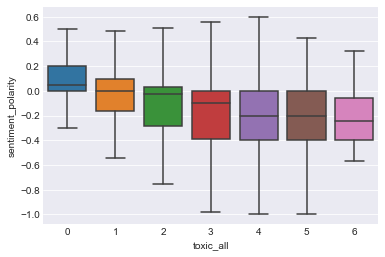

In [20]:
#sentiment polarity boxplot, the more tags the lower the polarity

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
sns.boxplot(x = train['toxic_all'], y = train['sentiment_polarity'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


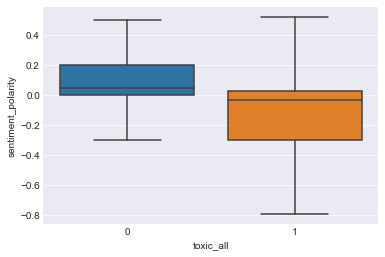

In [21]:
#without outliers, most toxic comments have negative sentiment polarity

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['sentiment_polarity'], showfliers = False)

In [22]:
print('average polarity toxic = ' + str(np.mean(train.sentiment_polarity[train['toxic_all'] >= 1])))
print('average polarity non-toxic = ' + str(np.mean(train.sentiment_polarity[train['toxic_all'] == 0])))

average polarity toxic = -0.1104715541869703
average polarity non-toxic = 0.09397305290173427


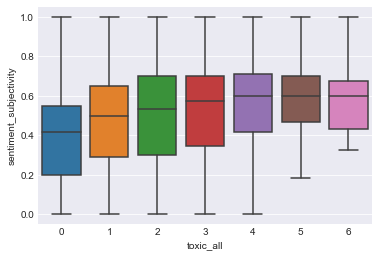

In [23]:
#sentiment subjectivity boxplot, the more tags the higher the subjectivity

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
sns.boxplot(x = train['toxic_all'], y = train['sentiment_subjectivity'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


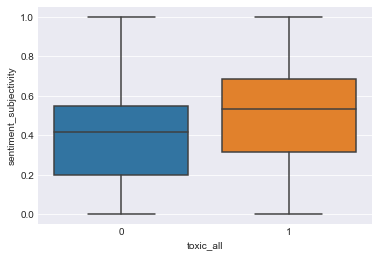

In [24]:
#binary response

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['sentiment_subjectivity'], showfliers = False)

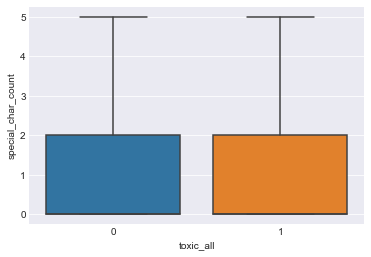

In [25]:
#count special characters, no relationship. some toxic outliers that contain many more special characters than non-toxic comments

special_chars = '!@#$%^&*()_+{}|'
train['special_char_count'] = train['comment_text'].apply(lambda x: len([char for char in x if char in special_chars]))

#boxplot

sns.boxplot(x = train['toxic_all'], y = train['special_char_count'], showfliers = False)

In [26]:
del train['special_char_count'] #not useful (?)

In [27]:
#unique token count

train['unique_token_count'] = train['comment_text'].apply(lambda x: len(set(nltk.word_tokenize(x))))
train['unique_token_count'].head()

0    44
1    23
2    43
3    90
4    17
Name: unique_token_count, dtype: int64

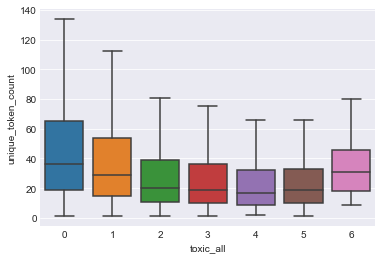

In [28]:
#token count box plot

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
sns.boxplot(x = train['toxic_all'], y = train['unique_token_count'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


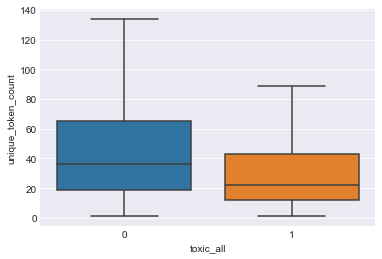

In [29]:
#binary response

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['unique_token_count'], showfliers = False)

In [30]:
#lexical diversity

train['lexical_diversity'] = train['comment_text'].apply(lambda x: len(set(nltk.word_tokenize(x))) / float(len(nltk.word_tokenize(x))))
train['lexical_diversity'].head()

0    0.897959
1    0.851852
2    0.895833
3    0.703125
4    0.944444
Name: lexical_diversity, dtype: float64

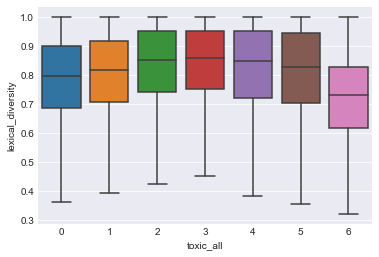

In [31]:
#lexical diversity box plot

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
sns.boxplot(x = train['toxic_all'], y = train['lexical_diversity'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


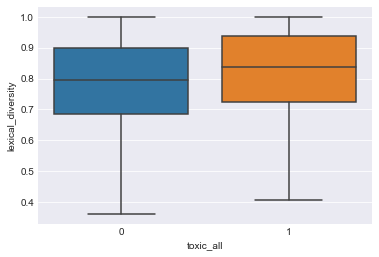

In [32]:
#binary response

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['lexical_diversity'], showfliers = False)

In [33]:
#longest word

train['longest_word_length'] = train['comment_text'].apply(lambda x: max(len(w) for w in nltk.word_tokenize(x.lower())))
train['longest_word_length'].head()

0    16
1    10
2    11
3    24
4     8
Name: longest_word_length, dtype: int64

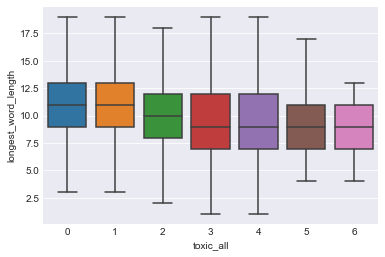

In [34]:
#longest word box plot

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
sns.boxplot(x = train['toxic_all'], y = train['longest_word_length'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


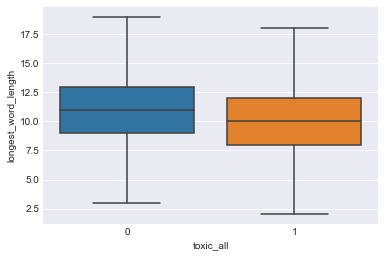

In [35]:
#binary response

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['longest_word_length'], showfliers = False)

In [36]:
#part of speech analysis (test) warning: very slow!!

from collections import Counter

text = 'hello world, my name is steven'

tokens = nltk.word_tokenize(text.lower())
text = nltk.Text(tokens)
tags = nltk.pos_tag(text)
counts = Counter(tag for word, tag in tags)
counts['NN']

#train['parts_of_speech'] = train['comment_text'].apply(lambda x: Counter(tag for word, tag in nltk.pos_tag(nltk.Text(nltk.word_tokenize(x.lower())))))
#train['parts_of_speech'].head()

2

(-0.5, 399.5, 199.5, -0.5)

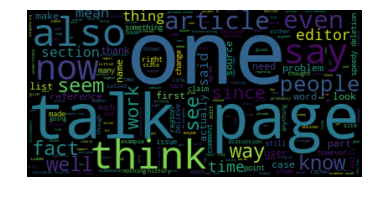

In [36]:
#generate and plot wordclouds

wordcloud = WordCloud().generate(' '.join(train['comment_text'].str.lower()))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

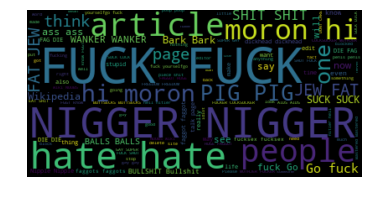

In [37]:
#toxic wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['toxic'] == 1].str.strip()))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

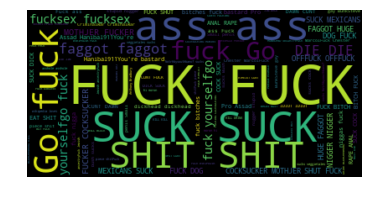

In [38]:
#severe toxic wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['severe_toxic'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

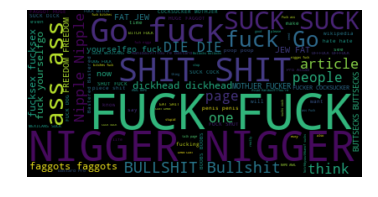

In [39]:
#obscene wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['obscene'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

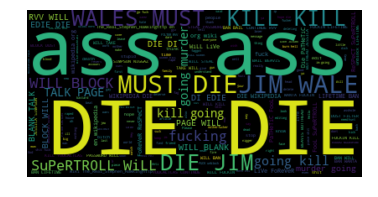

In [40]:
#threat wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['threat'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

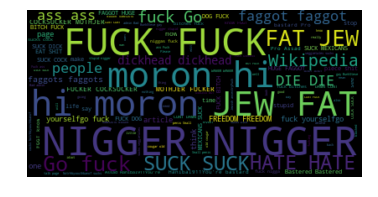

In [41]:
#insult wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['insult'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

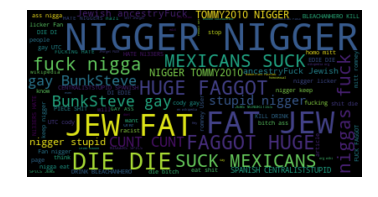

In [42]:
#identity hate wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['identity_hate'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

### Feature Engineering

1. All the above (length, sentiment, etc.)
    - How to incorcoprate this into term matrix? is it possible? will it help the eval. metric?

### Data Preprocessing

In [37]:
#decode feature column, remove special characters (needs work)

train['comment_text'] = train['comment_text'].str.lower() #lowercase
train['comment_text'] = train['comment_text'].str.replace('"', '') #remove double quotes
train['comment_text'] = train['comment_text'].str.replace('\'', '') #remove single quotes
train['comment_text'] = train['comment_text'].str.replace(' / ', ' ') #remove slashes
train['comment_text'] = train['comment_text'].str.replace('/', ' ') #remove slashes
train['comment_text'] = train['comment_text'].str.replace('.', ' ') #remove periods
train['comment_text'] = train['comment_text'].str.replace('\n', ' ') #remove new line characters

test['comment_text'] = test['comment_text'].str.lower() #lowercase
test['comment_text'] = test['comment_text'].str.replace('"', '') #remove double quotes
test['comment_text'] = test['comment_text'].str.replace('\'', '') #remove single quotes
test['comment_text'] = test['comment_text'].str.replace(' / ', ' ') #remove slashes
test['comment_text'] = test['comment_text'].str.replace('/', ' ') #remove slashes
test['comment_text'] = test['comment_text'].str.replace('.', ' ') #remove periods
test['comment_text'] = test['comment_text'].str.replace('\n', ' ') #remove new line characters

In [43]:
#gc.collect()

17163

### Model Selection (need to split into train test first)

1. Logistic Regression (complete)
2. Naive Bayes (not started)
3. NB-SVM (not started, have never used this model)
4. Others?

In [5]:
X, y = train['comment_text'], train.drop('comment_text', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(159571,)
(159571, 6)
(119678,)
(39893,)
(119678, 6)
(39893, 6)


In [38]:
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all,comment_length,sentiment_polarity,sentiment_subjectivity,unique_token_count,lexical_diversity,longest_word_length
26039,0,0,0,0,0,0,0,235,0.159091,0.475000,38,0.775510,14
123603,1,0,0,0,0,0,1,118,-0.166667,0.433333,23,0.958333,12
25463,0,0,0,0,0,0,0,67,0.000000,0.000000,14,0.933333,7
144724,0,0,0,0,0,0,0,319,0.109091,0.213636,47,0.691176,11
20510,0,0,0,0,0,0,0,195,-0.250000,0.750000,37,0.822222,9


In [10]:
#count vectorizer

vect = TfidfVectorizer(analyzer = lambda x: word_tokenize(x, how = 'stem'), strip_accents = 'unicode')

x_train_dtm = vect.fit_transform(X_train)
x_test_dtm = vect.transform(X_test)

#ensure columns match

print(x_train_dtm.shape)
print(x_test_dtm.shape)

(119678, 167556)
(39893, 167556)


In [41]:
#naive bayes

nb = MultinomialNB()

nb.fit(x_train_dtm, y_train['toxic'])
toxic_preds = nb.predict(x_test_dtm)

nb.fit(x_train_dtm, y_train['severe_toxic'])
severe_toxic_preds = nb.predict(x_test_dtm)

nb.fit(x_train_dtm, y_train['obscene'])
obscene_preds = nb.predict(x_test_dtm)

nb.fit(x_train_dtm, y_train['threat'])
threat_preds = nb.predict(x_test_dtm)

nb.fit(x_train_dtm, y_train['insult'])
insult_preds = nb.predict(x_test_dtm)

nb.fit(x_train_dtm, y_train['identity_hate'])
identity_hate_preds = nb.predict(x_test_dtm)

print(metrics.accuracy_score(y_test['toxic'], toxic_preds))
print(metrics.accuracy_score(y_test['severe_toxic'], severe_toxic_preds))
print(metrics.accuracy_score(y_test['obscene'], obscene_preds))
print(metrics.accuracy_score(y_test['threat'], threat_preds))
print(metrics.accuracy_score(y_test['insult'], insult_preds))
print(metrics.accuracy_score(y_test['identity_hate'], identity_hate_preds))

0.9146466798686487
0.9900734464693054
0.9510941769232697
0.9966911488231018
0.9516957862281603
0.9908003910460482


In [42]:
#logistic regression

logreg = LogisticRegression()

logreg.fit(x_train_dtm, y_train['toxic'])
toxic_preds = logreg.predict(x_test_dtm)

logreg.fit(x_train_dtm, y_train['severe_toxic'])
severe_toxic_preds = logreg.predict(x_test_dtm)

logreg.fit(x_train_dtm, y_train['obscene'])
obscene_preds = logreg.predict(x_test_dtm)

logreg.fit(x_train_dtm, y_train['threat'])
threat_preds = logreg.predict(x_test_dtm)

logreg.fit(x_train_dtm, y_train['insult'])
insult_preds = logreg.predict(x_test_dtm)

logreg.fit(x_train_dtm, y_train['identity_hate'])
identity_hate_preds = logreg.predict(x_test_dtm)

print(metrics.accuracy_score(y_test['toxic'], toxic_preds))
print(metrics.accuracy_score(y_test['severe_toxic'], severe_toxic_preds))
print(metrics.accuracy_score(y_test['obscene'], obscene_preds))
print(metrics.accuracy_score(y_test['threat'], threat_preds))
print(metrics.accuracy_score(y_test['insult'], insult_preds))
print(metrics.accuracy_score(y_test['identity_hate'], identity_hate_preds))

0.9577369463314366
0.9901235805780463
0.9772892487403805
0.9968415511493245
0.9713984909633269
0.9918030732208658


In [13]:
#stochastic gradient descent

sgd = SGDClassifier(loss = 'hinge', penalty='l2', alpha = 1e-3, random_state = 42, max_iter = 5, tol = None)

sgd.fit(x_train_dtm, y_train['toxic'])
toxic_preds = sgd.predict(x_test_dtm)

sgd.fit(x_train_dtm, y_train['severe_toxic'])
severe_toxic_preds = sgd.predict(x_test_dtm)

sgd.fit(x_train_dtm, y_train['obscene'])
obscene_preds = sgd.predict(x_test_dtm)

sgd.fit(x_train_dtm, y_train['threat'])
threat_preds = sgd.predict(x_test_dtm)

sgd.fit(x_train_dtm, y_train['insult'])
insult_preds = sgd.predict(x_test_dtm)

sgd.fit(x_train_dtm, y_train['identity_hate'])
identity_hate_preds = sgd.predict(x_test_dtm)

print(metrics.accuracy_score(y_test['toxic'], toxic_preds))
print(metrics.accuracy_score(y_test['severe_toxic'], severe_toxic_preds))
print(metrics.accuracy_score(y_test['obscene'], obscene_preds))
print(metrics.accuracy_score(y_test['threat'], threat_preds))
print(metrics.accuracy_score(y_test['insult'], insult_preds))
print(metrics.accuracy_score(y_test['identity_hate'], identity_hate_preds))

0.9190083473291053
0.9900985135236758
0.9618980773569298
0.9966660817687314
0.9565838618303963
0.9908254581004187


In [90]:
#neural networks

keras = Sequential()
keras.add(Dense(60, input_dim = 119678, activation = 'relu'))
keras.add(Dropout(0.2))
keras.add(Dense(30, activation = 'relu'))
keras.add(Dropout(0.2))
keras.add(Dense(1, activation = 'sigmoid'))

In [91]:
print(keras.output_shape)

(None, 1)


In [92]:
keras.output_shape
keras.summary()
keras.get_config()
keras.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 12)                240012    
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 9         
Total params: 240,125
Trainable params: 240,125
Non-trainable params: 0
_________________________________________________________________


[array([[-8.3507188e-03,  2.1476336e-03, -1.0161715e-02, ...,
         -8.3536087e-03, -1.2027863e-03, -7.3078210e-03],
        [-8.2258880e-03,  8.4926877e-03,  1.4614401e-02, ...,
          1.0856638e-02, -1.0661613e-02, -1.4897697e-03],
        [-5.1309066e-03,  7.4923597e-04, -1.0708433e-02, ...,
         -1.0090547e-02,  6.1608665e-04, -1.5095800e-02],
        ...,
        [ 5.0563905e-03, -1.4228772e-02,  3.0622818e-04, ...,
          4.2680893e-03,  2.1836516e-03,  6.8389252e-04],
        [ 6.8797339e-03, -3.3392645e-03,  2.5197621e-03, ...,
         -7.6691583e-03,  1.4487157e-02,  4.8581511e-05],
        [-3.0915961e-03,  4.2652898e-03,  4.6713650e-03, ...,
          3.5423394e-03, -1.6669096e-02, -1.0150807e-02]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.28781623, -0.46051446,  0.5043291 ,  0.4727075 ,  0.03591305,
         -0.5052286 ,  0.1871661 ,  0.37379056],
        [-0.48171896, -0.00348955,  0.02488011,  0.309

In [94]:
keras.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
keras.fit(x_train_dtm, y_train['toxic'], epochs = 1, batch_size = 1, verbose = 1)
#toxic_preds = keras.predict(x_test)

#print(metrics.accuracy_score(y_test['toxic'], toxic_preds))
#print(metrics.accuracy_score(y_test['severe_toxic'], severe_toxic_preds))
#print(metrics.accuracy_score(y_test['obscene'], obscene_preds))
#print(metrics.accuracy_score(y_test['threat'], threat_preds))
#print(metrics.accuracy_score(y_test['insult'], insult_preds))
#print(metrics.accuracy_score(y_test['identity_hate'], identity_hate_preds))

Epoch 1/1
119678/119678 [==============================] - 458s 4ms/step - loss: 0.1202 - acc: 0.9595


In [99]:
#toxic_preds = keras.predict(x_test_dtm)
score = keras.evaluate(x_train_dtm, y_train['toxic'], verbose = 1)

#print(metrics.accuracy_score(y_test['toxic'], toxic_preds))
print(score)

119678/119678 [==============================] - 19s 157us/step
[0.10641145009914342, 0.9645799562168419]


### Parameter Tuning

1. N-gram ranges
2. Stemming, lemmatizing
3. Stop words
4. Work tokenization
    - Tfidf (done)
    - Term freq. (done)
5. Max features

In [6]:
text_clf = Pipeline([('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

In [7]:
#grid search

parameters = {#'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': (None, 'english'),
    'vect__max_features': (None, 100000, 50000, 25000),
    'vect__strip_accents': (None, 'ascii', 'unicode'),
    'tfidf__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)
gs_clf = gs_clf.fit(X_train, y_train['toxic'])

In [8]:
#check out best params

gs_clf.best_score_

for param_name in sorted(parameters.keys()):
    print('%s: %r' % (param_name, gs_clf.best_params_[param_name]))

clf__C: 10
tfidf__use_idf: True
vect__max_features: 100000
vect__stop_words: None
vect__strip_accents: 'ascii'


### Fit the Model

In [9]:
#insantiate and fit transform tfidf vectorizer (term frequency)

vect = TfidfVectorizer(analyzer = lambda x: word_tokenize(x, how = 'stem'), strip_accents = 'ascii', max_features = 100000)

#create document term matrices

train_dtm = vect.fit_transform(train['comment_text'])
test_dtm = vect.transform(test['comment_text'])

#ensure columns match

print(train_dtm.shape)
print(test_dtm.shape)

(159571, 100000)
(153164, 100000)


In [10]:
#fit logistic regression for first response

logreg = LogisticRegression(C = 10)
logreg.fit(train_dtm, train['toxic'])
toxic_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['toxic'])

#second response

logreg.fit(train_dtm, train['severe_toxic'])
severe_toxic_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['severe_toxic'])

#third response

logreg.fit(train_dtm, train['obscene'])
obscene_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['obscene'])

#fourth response

logreg.fit(train_dtm, train['threat'])
threat_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['threat'])

#fifth response

logreg.fit(train_dtm, train['insult'])
insult_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['insult'])

#sixth response

logreg.fit(train_dtm, train['identity_hate'])
identity_hate_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['identity_hate'])

In [11]:
result = pd.DataFrame(test_ids, columns = ['id'])
result['toxic'] = toxic_preds
result['severe_toxic'] = severe_toxic_preds
result['obscene'] = obscene_preds
result['threat'] = threat_preds
result['insult'] = insult_preds
result['identity_hate'] = identity_hate_preds
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999989,0.194416,0.999952,0.135390,0.994069,0.433419
1,0000247867823ef7,0.000335,0.000481,0.000270,0.000037,0.001814,0.000554
2,00013b17ad220c46,0.007070,0.001193,0.003330,0.000171,0.003809,0.000616
3,00017563c3f7919a,0.000866,0.002504,0.000791,0.000198,0.003171,0.000122
4,00017695ad8997eb,0.003228,0.000166,0.001698,0.000616,0.001480,0.000387


In [12]:
result.to_csv('submission.csv', index = False)

In [12]:
#neural networks

keras = Sequential()
keras.add(Dense(12, input_dim = 204948, activation = 'relu'))
keras.add(Dropout(0.2))
keras.add(Dense(8, activation = 'relu'))
keras.add(Dropout(0.2))
keras.add(Dense(1, activation = 'sigmoid'))

keras.output_shape
keras.summary()
keras.get_config() 
keras.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                2459388   
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,459,501
Trainable params: 2,459,501
Non-trainable params: 0
_________________________________________________________________


[array([[-0.00143051, -0.00128704, -0.00418132, ...,  0.00479017,
         -0.00122176, -0.00332956],
        [-0.0001842 ,  0.00238783,  0.0044218 , ...,  0.00313114,
         -0.00062754,  0.00078586],
        [ 0.00306383, -0.0048287 , -0.00418027, ..., -0.00019167,
         -0.00396731, -0.00012116],
        ...,
        [ 0.00452912,  0.00403254,  0.00152235, ...,  0.00196344,
         -0.00476741,  0.00057185],
        [-0.00403036, -0.0028738 , -0.00248847, ...,  0.00173729,
         -0.00084754, -0.00134745],
        [ 0.00168144, -0.00281901,  0.00391044, ..., -0.00315874,
          0.00341004, -0.00242604]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.19952399,  0.07813686,  0.01991612,  0.23197031, -0.23117414,
          0.48793316,  0.48832   , -0.4216398 ],
        [ 0.19823653,  0.45670903, -0.21174002, -0.17117336,  0.3445397 ,
         -0.33401552,  0.3764214 ,  0.29161018],
        [ 0.14057976, -0.01541412, -0.1

In [13]:
keras.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
keras.fit(train_dtm, train['toxic'], epochs = 2, batch_size = 1, verbose = 1)
toxic_preds = pd.DataFrame(keras.predict_proba(test_dtm), columns = ['toxic'])

keras.fit(train_dtm, train['severe_toxic'], epochs = 2, batch_size = 1, verbose = 1)
severe_toxic_preds = pd.DataFrame(keras.predict_proba(test_dtm), columns = ['severe_toxic'])

keras.fit(train_dtm, train['obscene'], epochs = 2, batch_size = 1, verbose = 1)
obscene_preds = pd.DataFrame(keras.predict_proba(test_dtm), columns = ['obscene'])

keras.fit(train_dtm, train['threat'], epochs = 2, batch_size = 1, verbose = 1)
threat_preds = pd.DataFrame(keras.predict_proba(test_dtm), columns = ['threat'])

keras.fit(train_dtm, train['insult'], epochs = 2, batch_size = 1, verbose = 1)
insult_preds = pd.DataFrame(keras.predict_proba(test_dtm), columns = ['insult'])

keras.fit(train_dtm, train['identity_hate'], epochs = 2, batch_size = 1, verbose = 1)
identity_hate_preds = pd.DataFrame(keras.predict_proba(test_dtm), columns = ['identity_hate'])

Epoch 1/2
159571/159571 [==============================] - 1114s 7ms/step - loss: 0.1852 - acc: 0.9421
Epoch 2/2
159571/159571 [==============================] - 1121s 7ms/step - loss: 0.1660 - acc: 0.9458
Epoch 1/2
159571/159571 [==============================] - 1114s 7ms/step - loss: 0.0329 - acc: 0.9886
Epoch 2/2
159571/159571 [==============================] - 1108s 7ms/step - loss: 0.0345 - acc: 0.9900
Epoch 1/2
159571/159571 [==============================] - 1145s 7ms/step - loss: 0.1408 - acc: 0.9531
Epoch 2/2
159571/159571 [==============================] - 1141s 7ms/step - loss: 0.1102 - acc: 0.9699
Epoch 1/2
159571/159571 [==============================] - 1195s 7ms/step - loss: 0.0201 - acc: 0.9961
Epoch 2/2
159571/159571 [==============================] - 1164s 7ms/step - loss: 0.0195 - acc: 0.9969
Epoch 1/2
159571/159571 [==============================] - 2474s 16ms/step - loss: 0.1464 - acc: 0.9577
Epoch 2/2
159571/159571 [==============================] - 1156s 7ms/ste

In [14]:
result = pd.DataFrame(test_ids, columns = ['id'])
result['toxic'] = toxic_preds
result['severe_toxic'] = severe_toxic_preds
result['obscene'] = obscene_preds
result['threat'] = threat_preds
result['insult'] = insult_preds
result['identity_hate'] = identity_hate_preds
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.766984,0.002966,0.692350,4.624309e-05,0.327064,0.048723
1,0000247867823ef7,0.003071,0.000079,0.001942,2.609713e-06,0.001154,0.004645
2,00013b17ad220c46,0.079431,0.014686,0.036750,1.898374e-03,0.032783,0.023782
3,00017563c3f7919a,0.003129,0.000004,0.000769,1.536445e-08,0.000466,0.000915
4,00017695ad8997eb,0.035699,0.001201,0.025317,5.441480e-05,0.022443,0.011047


In [15]:
result.to_csv('submission.csv', index = False)

### Submission Results

1. baseline logistic regression CountVectorizer = .084
2. baseline logistic regression TfidfVectorizer = .057
3. baseline logistic regression TfidfVectorizer stemming work tokenizer = .055
4. same as above with some text cleaning = 

In [25]:
#test

sentence = 'hello world'
letters = 'abcdefghijklmnopqrstuvwxyz'
vowels_count = len([char for char in sentence if char in letters])
vowels_count

10

In [26]:
sentence = 'hello world!@^%#$&'
letters = 'abcdefghijklmnopqrstuvwxyz'
vowels_count = len([char for char in sentence if char in letters])
vowels_count

10

In [76]:
print(type(x_train_dtm))
print(type(train_dtm))

print(type(x_test_dtm))
print(type(test_dtm))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
<class 'scipy.sparse.csr.csr_matrix'>


In [18]:
gc.collect()

872